<a href="https://colab.research.google.com/github/nprimavera/Financial-Models/blob/main/Regression_Model_to_Predict_Stock_Prices_(Extrapolation).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Linear Regression Model**

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [2]:
# Download stock data
data = yf.download("AAPL", start="2020-01-01", end="2024-01-01")
#print(f"\n\nApple Data: \n{data}\n")

# Compute daily return
"""
Return (pct_change() in pandas)
    - looks at percentage change
    - Return = P_t - P_t-n / P_t-n
"""
data['Return'] = data['Close'].pct_change()

# Print data
data = data.rename(columns={
    'Open': 'AAPL_Open',
    'High': 'AAPL_High',
    'Low': 'AAPL_Low',
    'Close': 'AAPL_Close',
    'Volume': 'AAPL_Volume',
    'Adj Close': 'AAPL_Adj_Close',
    'Return': 'AAPL_Return'
})

data = data.reset_index() # make data a column

# Drop NaN values
data = data.dropna()

print("\n\nCleaned AAPL Stock Data:\n")
print(data)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed



Cleaned AAPL Stock Data:

Price        Date  AAPL_Close   AAPL_High    AAPL_Low   AAPL_Open AAPL_Volume  \
Ticker                   AAPL        AAPL        AAPL        AAPL        AAPL   
1      2020-01-03   71.914810   72.676439   71.689950   71.847110   146322800   
2      2020-01-06   72.487854   72.526541   70.783256   71.034717   118387200   
3      2020-01-07   72.146950   72.753831   71.926922   72.497537   108872000   
4      2020-01-08   73.307518   73.609752   71.849540   71.849540   132079200   
5      2020-01-09   74.864632   75.058059   74.035303   74.286756   170108400   
...           ...         ...         ...         ...         ...         ...   
1001   2023-12-22  192.192551  193.989390  191.567126  193.761051    37122800   
1002   2023-12-26  191.646545  192.480435  191.428144  192.202472    28919300   
1003   2023-12-27  191.745834  192.093296  189.700813  191.090644    48087700   
1004   2023-12-28  192.172699  193.244849  191.765676  192.728625    34049900   


**Model Features**

SMA (Simple Moving Average):

*  SMA is the unweighted average of the last n data points (typically prices) in a time series.
* It's used to smooth out short-term fluctuations and highlight longer-term trends in data.
*  SMA_t = 1/n * ∑^n-1_{i=0} (Price_t-i) where P_t-i is the price at time t-i and n is the window length (5 days, 10 days)
* ex: SMA_5 = 1/5 * (100 + 102 + 101 + 104 + 106) = 102.6

Momentum:
* Difference between current and previous price:  Momentum = Current Price - Price from N days ago
* The rate of change of an asset's price - how fast and in what direction a stock is moving
* Measures whether a stock has been gaining or losing value over a certain time window
* ex: Momentum = 150 - 135 = 15, stock price has a positive momentum
* Used when you want to track raw gains/losses and returns for normalized changes across assets

Volatility:
* Rolling standard deviation (ex. 10 days) of returns

Lagged Returns:
* Add lagged versions of returns (ex. yesterday's return)

Price Ratio:
* Close / SMA_10 to see relative price



In [3]:
# Add features
data['SMA_5'] = data['AAPL_Close'].rolling(window=5).mean()           # SMA for 5 days
data['SMA_10'] = data['AAPL_Close'].rolling(window=10).mean()         # SMA for 10 days
#print(type(data['SMA_10']))
#print(data['SMA_10'])
data['Momentum'] = data['AAPL_Close'] - data['AAPL_Close'].shift(10)  # Momentum for 10 days
data['Volatility'] = data['AAPL_Return'].rolling(window=10).std()     # Volatility for 10 days
data['Return_Lag1'] = data['AAPL_Return'].shift(1)                    # Lagged return for 1 day
data['Return_Lag5'] = data['AAPL_Return'].shift(5)                    # Lagged return for 5 days
#data['Price_Ratio'] = data['AAPL_Close'] / data['SMA_10']             # Price ratio for 10 days

# Drop NaN values
data = data.dropna()

# Define X and y
X = data[['SMA_5', 'SMA_10', 'Momentum', 'Volatility', 'Return_Lag1', 'Return_Lag5']]
y = data['AAPL_Return'].shift(-1)  # next-day return
X, y = X[:-1], y[:-1]  # Align

print("X Data:\n\n", X)
print("\ny Data (next-day return):\n\n", y)

X Data:

 Price        SMA_5      SMA_10  Momentum Volatility Return_Lag1 Return_Lag5
Ticker                                                                     
11       76.160603   74.864383  5.150070   0.011771    0.012526    0.002260
12       76.141745   75.269861  4.054779   0.012535    0.011071    0.021365
13       76.384499   75.736751  4.668900   0.012048   -0.006777   -0.013503
14       76.766039   76.124577  3.878265   0.011554    0.003569   -0.004286
15       76.914502   76.334451  2.098732   0.010288    0.004816    0.012526
...            ...         ...       ...        ...         ...         ...
1000    194.557239  194.533414  0.407028   0.009352   -0.010714    0.000758
1001    193.769006  194.323947 -2.094666   0.009145   -0.000770   -0.002726
1002    193.205133  194.311041 -0.129059   0.008196   -0.005548   -0.008503
1003    192.452646  194.156177 -1.548645   0.007718   -0.002841    0.005360
1004    192.204465  193.721361 -4.348160   0.004933    0.000518   -0.010714

[

**Linear Regression**

Predicted returns (first 5):
 [[-2.74292984e-03]
 [ 2.05369672e-03]
 [ 4.58699796e-04]
 [ 4.44457349e-05]
 [ 2.71642815e-03]]

Actual returns (first 5):
 806   -0.005454
807    0.015484
808    0.011944
809   -0.009103
810    0.006969
Name: AAPL_Return, dtype: float64

Model Score: -0.0783909698566021


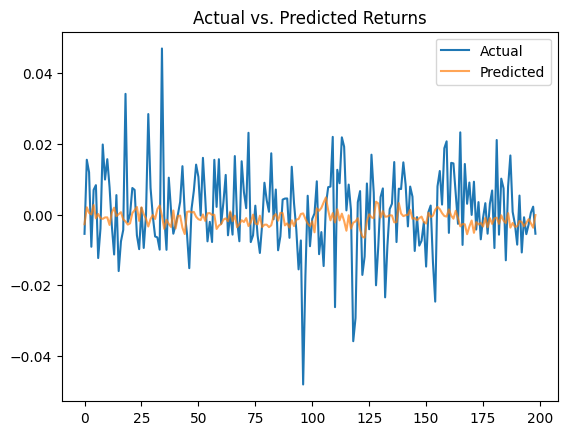

In [4]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Fit model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict future returns
y_pred = model.predict(X_test)
y_pred_reshaped = y_pred.reshape(-1, 1)

# Evaluate (simple)
print("Predicted returns (first 5):\n", y_pred_reshaped[:5])
print("\nActual returns (first 5):\n", y_test[:5])
print("\nModel Score:", model.score(X_test, y_test))

# Plot
plt.plot(y_test.values, label="Actual")
plt.plot(y_pred, label="Predicted", alpha=0.7)
plt.legend()
plt.title("Actual vs. Predicted Returns")
plt.show()